In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Loading the Dataset**

In [76]:
df = pd.read_csv("E:\Logistics Project\data\logistics_shipments_dataset.csv")
df.head()

,Shipment_ID,Origin_Warehouse,Destination,Carrier,Shipment_Date,Delivery_Date,Weight_kg,Cost,Status,Distance_miles,Transit_Days
0,SH10000,Warehouse_MIA,San Francisco,UPS,2023-10-02,2023-10-04,25.7,67.46,Delivered,291,2
1,SH10001,Warehouse_MIA,Atlanta,DHL,2023-12-06,2023-12-09,38.9,268.85,Delivered,1225,3
2,SH10002,Warehouse_LA,Houston,DHL,2023-09-18,2023-09-20,37.2,74.35,Delivered,220,2
3,SH10003,Warehouse_BOS,Seattle,OnTrac,2023-01-26,2023-02-04,42.6,187.04,Delivered,1156,9
4,SH10004,Warehouse_SF,Dallas,OnTrac,2023-06-03,2023-06-06,7.9,120.01,Delivered,1017,3


In [77]:
df.shape

(2000, 11)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Shipment_ID       2000 non-null   object 
 1   Origin_Warehouse  2000 non-null   object 
 2   Destination       2000 non-null   object 
 3   Carrier           2000 non-null   object 
 4   Shipment_Date     2000 non-null   object 
 5   Delivery_Date     1968 non-null   object 
 6   Weight_kg         2000 non-null   float64
 7   Cost              1959 non-null   float64
 8   Status            2000 non-null   object 
 9   Distance_miles    2000 non-null   int64  
 10  Transit_Days      2000 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 172.0+ KB


In [79]:
df.describe()

,Weight_kg,Cost,Distance_miles,Transit_Days
count,2000.000000,1959.000000,2000.000000,2000.000000
mean,30.184800,205.161598,1275.868000,4.182500
std,124.967053,222.586082,691.382829,1.837902
min,0.000000,17.890000,101.000000,1.000000
25%,12.300000,117.710000,690.250000,3.000000
50%,20.700000,196.420000,1262.500000,4.000000
75%,33.925000,272.115000,1867.250000,5.000000
max,5404.200000,6562.210000,2499.000000,12.000000


**Converting Dates** 

In [80]:
date_cols = ['Shipment_Date', 'Delivery_Date', 'Expected_Delivery_Date']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

**Feature Engineering**

In [81]:
if 'Shipment_Date' in df.columns and 'Delivery_Date' in df.columns:
    df['Delivery_Time_Days'] = (df['Delivery_Date'] - df['Shipment_Date']).dt.days

**Handling Missing Values** 

In [82]:
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [83]:
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [84]:
df.drop_duplicates(inplace=True)

**Exploratory Data Analysis (EDA)**

**Shipment Status Distribution**

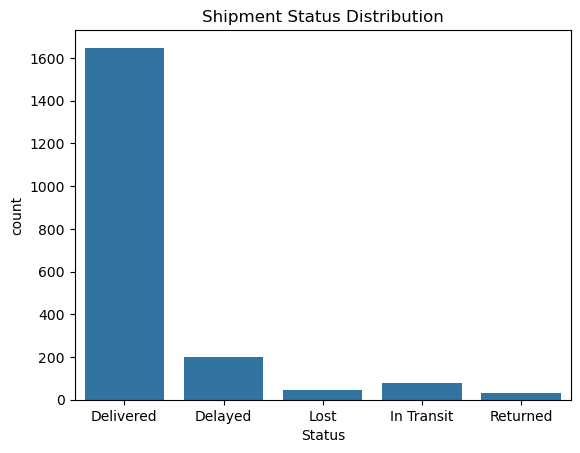

In [85]:
sns.countplot(x='Status', data=df)
plt.title("Shipment Status Distribution")
plt.show()

**Shipments Trends Over Time**

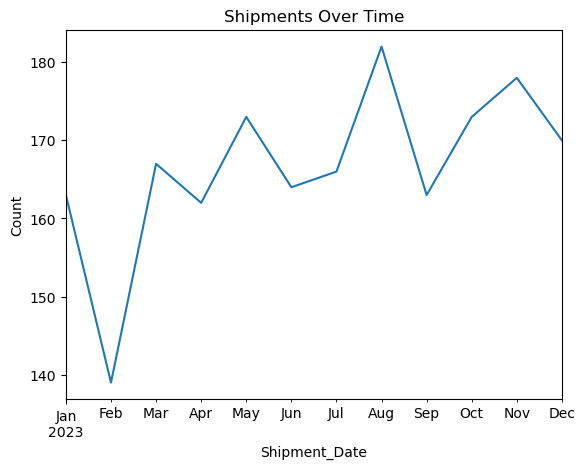

In [86]:
df.groupby(df['Shipment_Date'].dt.to_period("M")).size().plot(kind='line')
plt.title("Shipments Over Time")
plt.ylabel("Count")
plt.show()

**Delay Distributions**

In [87]:
# Create Delay_Days based on actual vs planned transit
if 'Delivery_Time_Days' in df.columns and 'Transit_Days' in df.columns:
    df['Delay_Days'] = df['Delivery_Time_Days'] - df['Transit_Days']

print(df[['Delivery_Time_Days', 'Transit_Days', 'Delay_Days']].head())

   Delivery_Time_Days  Transit_Days  Delay_Days
0                 2.0             2         0.0
1                 3.0             3         0.0
2                 2.0             2         0.0
3                 9.0             9         0.0
4                 3.0             3         0.0


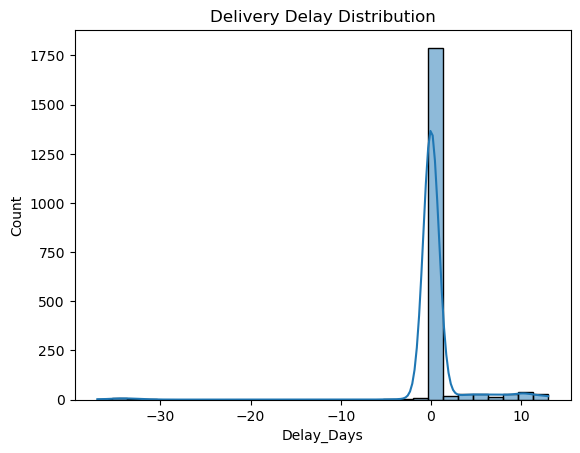

In [88]:
sns.histplot(df['Delay_Days'].dropna(), bins=30, kde=True)
plt.title("Delivery Delay Distribution")
plt.show()

**Carrier Performance**

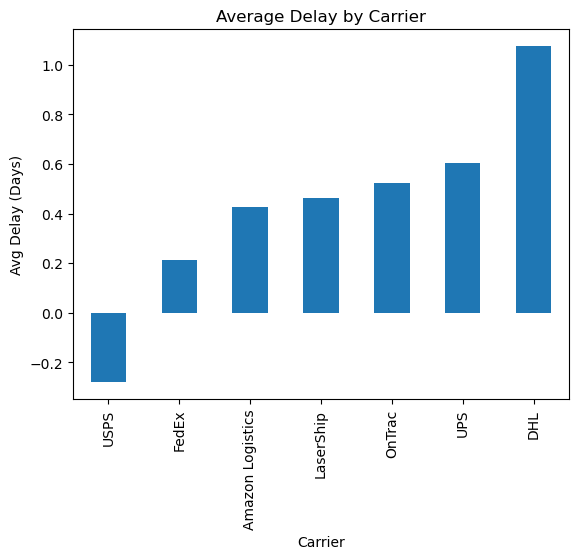

In [89]:
df.groupby('Carrier')['Delay_Days'].mean().sort_values().plot(kind='bar')
plt.title("Average Delay by Carrier")
plt.ylabel("Avg Delay (Days)")
plt.show()

**Business Use Case KPIs**

**On Time Delivery %**

In [90]:
on_time = (df['Delay_Days'] <= 0).mean() * 100
print("On-Time Delivery %:", round(on_time, 2))

On-Time Delivery %: 89.4


**Average Delivery Time**

In [91]:
avg_time = df['Delivery_Time_Days'].mean()
print("Average Delivery Time:", avg_time)

Average Delivery Time: 4.6085


**Top 10 Routes**

In [92]:
top_routes = df.groupby(['Origin_Warehouse', 'Destination']).size().sort_values(ascending=False).head(10)
print("Top Routes:\n", top_routes)

Top Routes:
 Origin_Warehouse  Destination
Warehouse_CHI     Denver         25
Warehouse_LA      Dallas         24
Warehouse_MIA     Detroit        23
Warehouse_LA      New York       22
                  Chicago        21
Warehouse_BOS     Chicago        19
Warehouse_DEN     Phoenix        19
Warehouse_SF      Dallas         19
Warehouse_DEN     Minneapolis    19
Warehouse_ATL     Minneapolis    19
dtype: int64


In [93]:
pivot = df.pivot_table(
    index='Origin_Warehouse',
    columns='Destination',
    values='Shipment_ID',
    aggfunc='count',
    fill_value=0
)
print(pivot)

Destination       Atlanta  Boston  Chicago  Dallas  Denver  Detroit  Houston  \
Origin_Warehouse                                                               
Warehouse_ATL          13      18       15      16      13       13       16   
Warehouse_BOS          11      10       19      13      13       12       13   
Warehouse_CHI          17      11       14       6      25       17       15   
Warehouse_DEN          18      13       10      11      11        7       11   
Warehouse_HOU          11      13       16      15      14       18       11   
Warehouse_LA            9      10       21      24      13        9       15   
Warehouse_MIA          15      12       18       8      16       23        8   
Warehouse_NYC          10       5       14      14       7       12       15   
Warehouse_SEA          15      12       15      11      16       14       13   
Warehouse_SF           14      15       12      19      14       16        9   

Destination       Los Angeles  Miami  M

**Predictive Analysis**

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [95]:
df['Is_Delayed'] = (df['Delay_Days'] > 0).astype(int)

In [96]:
features = ['Origin_Warehouse', 'Carrier', 'Weight_kg', 'Cost']
X = pd.get_dummies(df[features], drop_first=True)
y = df['Is_Delayed']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [98]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       541
           1       0.25      0.03      0.06        59

    accuracy                           0.90       600
   macro avg       0.58      0.51      0.50       600
weighted avg       0.84      0.90      0.86       600



The model was evaluated using accuracy, precision, recall, and F1-score.

**Results:**
- Accuracy: **90%**
- Precision (On-time): **0.90**
- Recall (On-time): **0.99**
- Precision (Delayed): **0.25**
- Recall (Delayed): **0.03**

**Interpretation:**
- The model is excellent at predicting on-time shipments, correctly identifying nearly all of them.
- However, it performs very poorly at identifying delayed shipments (only 3% recall).
- The high overall accuracy is misleading because of **class imbalance** (majority of shipments are on-time).
- Weighted metrics are inflated by the dominant class.